# Learning Positional Encoding

This is first concept being experimented that is used in NeRF. A NeRF is basically overfitting a neural network to a particular scene. The basic concept of postional encoding is implemented in the NeRF.

Simplifying into 2d data that is image instead of a 3d scene. If we try to overfit a network by passing the pixel coordinates and predicting the respective RGB values, the network is not able to reconstruct well. Even though the parameters in the netowrk is greater then the number of pixels in the image.

The out put is the blurred image. So for proper reconstruction the concept of positional encoding is used.

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

In [ ]:
img =cv2.imread("/content/test.jpeg")

## Original Image

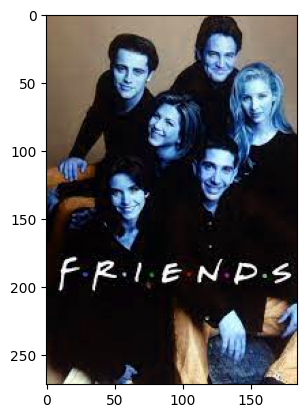

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)

## Without Postional Encoding

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Input

In [ ]:
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='relu'))

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 256)               768       
                                                                 
 dense_20 (Dense)            (None, 512)               131584    
                                                                 
 dense_21 (Dense)            (None, 1024)              525312    
                                                                 
 dense_22 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_23 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_24 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_25 (Dense)            (None, 512)              

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
height, width,_ = img.shape
x_coordinates = np.arange(width)
y_coordinates = np.arange(height)

pixel_coordinates = np.transpose([np.repeat(y_coordinates, width),
                                      np.tile(x_coordinates, height)])


In [ ]:
pixel_coordinates

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [271, 182],
       [271, 183],
       [271, 184]])

In [ ]:
gt = np.reshape(img, (-1,3))

In [ ]:
gt[12000]

array([202, 245, 255], dtype=uint8)

In [ ]:
pixel_coordinates[12000]

array([ 64, 160])

In [ ]:
img[64][160]

array([202, 245, 255], dtype=uint8)

In [ ]:
print(gt.shape)
print(pixel_coordinates.shape)

(50320, 3)
(50320, 2)


In [ ]:
model.fit(pixel_coordinates, gt, epochs=200, batch_size= 1024)

Epoch 1/200
50/50 [==============================] - 4s 13ms/step - loss: 5661.5874
Epoch 2/200
50/50 [==============================] - 0s 10ms/step - loss: 4850.1226
Epoch 3/200
50/50 [==============================] - 0s 10ms/step - loss: 4709.2510
Epoch 4/200
50/50 [==============================] - 0s 10ms/step - loss: 4627.8369
Epoch 5/200
50/50 [==============================] - 0s 10ms/step - loss: 4427.4072
Epoch 6/200
50/50 [==============================] - 0s 10ms/step - loss: 4114.6958
Epoch 7/200
50/50 [==============================] - 0s 10ms/step - loss: 3810.4771
Epoch 8/200
50/50 [==============================] - 0s 9ms/step - loss: 3552.4214
Epoch 9/200
50/50 [==============================] - 0s 10ms/step - loss: 3403.4785
Epoch 10/200
50/50 [==============================] - 0s 10ms/step - loss: 3252.5217
Epoch 11/200
50/50 [==============================] - 0s 10ms/step - loss: 3057.4998
Epoch 12/200
50/50 [==============================] - 0s 10ms/step - loss: 

In [ ]:
pred = model.predict(pixel_coordinates)

1573/1573 [==============================] - 3s 2ms/step


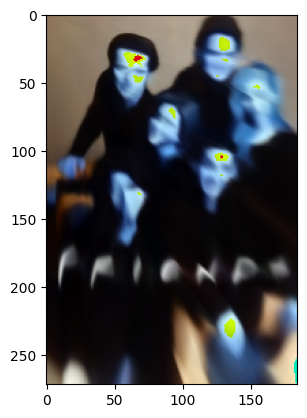

In [ ]:
pred_img = np.array(pred.reshape(img.shape),dtype='uint8')
plt.imshow(pred_img)

We can see that model is not able to reconstruct the original image properly. This is because for slight change in the coordinates the RGB values might change drastically due to which model tries to learn the average of nearby pixel values hence resulting in gaussian blur

#Positional Encoding

In [ ]:
pixel_coordinates

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [271, 182],
       [271, 183],
       [271, 184]])

In [ ]:
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, num_features):
        super(PositionalEncodingLayer, self).__init__()
        self.num_features = num_features

    def build(self, input_shape):
        pass

    def encode(self, input, w):
        input = tf.cast(input, tf.float32)
        w = tf.cast(w, tf.float32)
        return tf.math.sin(tf.math.pow(2.0, w)* input)

    def call(self, inputs):
        encoded = [self.encode(inputs, w) for w in range(self.num_features)]
        encoded = tf.cast(encoded, dtype=tf.float32)
        # print(encoded)
        # print(encoded.shape)
        encoded = tf.transpose(encoded, perm=[1, 0, 2])
        # print(encoded)
        # print(encoded.shape)
        encoded = tf.reshape(encoded, (-1,self.num_features * 2))
        # print(encoded.shape)
        encoded = tf.cast(encoded, tf.float32)
        return encoded

In [ ]:
pl = PositionalEncodingLayer(5)
pl(tf.constant([[2,4],[2,5],[7,9]]))

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[ 0.90929747, -0.7568025 , -0.7568025 ,  0.98935825,  0.98935825,
        -0.28790334, -0.28790334,  0.5514267 ,  0.5514267 ,  0.92002606],
       [ 0.90929747, -0.9589243 , -0.7568025 , -0.54402107,  0.98935825,
         0.9129453 , -0.28790334,  0.7451132 ,  0.5514267 , -0.9938887 ],
       [ 0.6569866 ,  0.4121185 ,  0.9906074 , -0.75098723,  0.2709058 ,
        -0.99177885, -0.521551  ,  0.25382337, -0.88999563, -0.4910216 ]],
      dtype=float32)>

In [ ]:
pl(tf.constant([[3,4],[2,5],[7,9]]))

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[ 0.14112   , -0.7568025 , -0.2794155 ,  0.98935825, -0.53657293,
        -0.28790334, -0.9055784 ,  0.5514267 , -0.7682547 ,  0.92002606],
       [ 0.90929747, -0.9589243 , -0.7568025 , -0.54402107,  0.98935825,
         0.9129453 , -0.28790334,  0.7451132 ,  0.5514267 , -0.9938887 ],
       [ 0.6569866 ,  0.4121185 ,  0.9906074 , -0.75098723,  0.2709058 ,
        -0.99177885, -0.521551  ,  0.25382337, -0.88999563, -0.4910216 ]],
      dtype=float32)>

In [ ]:
model = Sequential()
model.add(Input(shape=(2,)))
model.add(PositionalEncodingLayer(5))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='relu'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoding_layer_3  (None, 10)               0         
 1 (PositionalEncodingLayer)                                     
                                                                 
 dense_10 (Dense)            (None, 256)               2816      
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 1024)              1049600   
                                                      

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.fit(pixel_coordinates, gt, epochs=200, batch_size= 1024)

Epoch 1/200
50/50 [==============================] - 1s 14ms/step - loss: 5180.2002
Epoch 2/200
50/50 [==============================] - 1s 10ms/step - loss: 4390.3843
Epoch 3/200
50/50 [==============================] - 0s 9ms/step - loss: 3413.1506
Epoch 4/200
50/50 [==============================] - 0s 10ms/step - loss: 3395.5005
Epoch 5/200
50/50 [==============================] - 0s 10ms/step - loss: 3330.9746
Epoch 6/200
50/50 [==============================] - 0s 10ms/step - loss: 3227.8938
Epoch 7/200
50/50 [==============================] - 0s 10ms/step - loss: 3205.2249
Epoch 8/200
50/50 [==============================] - 0s 9ms/step - loss: 3142.5972
Epoch 9/200
50/50 [==============================] - 0s 10ms/step - loss: 3089.5466
Epoch 10/200
50/50 [==============================] - 0s 9ms/step - loss: 3037.5737
Epoch 11/200
50/50 [==============================] - 0s 9ms/step - loss: 3024.9558
Epoch 12/200
50/50 [==============================] - 0s 9ms/step - loss: 2925

In [ ]:
pred = model.predict(pixel_coordinates)

1573/1573 [==============================] - 3s 2ms/step


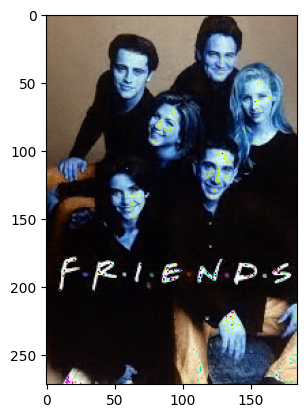

In [ ]:
pred_img = np.array(pred.reshape(img.shape),dtype='uint8')
plt.imshow(pred_img)

We can see that using positional encoding the model is able to reconstruct the image properly. We are using fourier features for encoding the pixel coordinates. Due to which for slight changes in the pixeel coordinates they are represented by totally different vectors hence model is able to overfit on the image properly.